In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import numpy as np
import pandas as pd
import warnings
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import ticker
import missingno as msno
import seaborn as sns
import gc
%matplotlib inline

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('float_format', '{:f}'.format)
warnings.filterwarnings('ignore')

In [3]:

train = pd.read_csv('/content/gdrive/MyDrive/song-popularity-prediction/train.csv')
test = pd.read_csv('/content/gdrive/MyDrive/song-popularity-prediction/test.csv')
ss    = pd.read_csv('/content/gdrive/MyDrive/song-popularity-prediction/sample_submission.csv')

In [4]:
train.head()

,id,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,song_popularity
0,0,212990.000000,0.642286,0.856520,0.707073,0.002001,10.000000,nan,-5.619088,0,0.082570,158.386236,4,0.734642,0
1,1,nan,0.054866,0.733289,0.835545,0.000996,8.000000,0.436428,-5.236965,1,0.127358,102.752988,3,0.711531,1
2,2,193213.000000,nan,0.188387,0.783524,-0.002694,5.000000,0.170499,-4.951759,0,0.052282,178.685791,3,0.425536,0
3,3,249893.000000,0.488660,0.585234,0.552685,0.000608,0.000000,0.094805,-7.893694,0,0.035618,128.715630,3,0.453597,0
4,4,165969.000000,0.493017,nan,0.740982,0.002033,10.000000,0.094891,-2.684095,0,0.050746,121.928157,4,0.741311,0


In [5]:
test.head()

,id,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
0,0,308523.000000,0.019845,nan,0.908939,0.001438,nan,0.112832,-8.890172,0,0.082714,126.129304,4,0.399620
1,1,200011.000000,0.070119,0.731256,0.444655,0.002020,10.000000,0.139040,-6.301214,0,0.061685,86.448149,3,0.499424
2,2,279758.000000,0.810637,0.568858,0.125466,0.898841,0.000000,0.226614,-11.542478,0,0.041868,99.544351,3,0.564951
3,3,249197.000000,nan,0.871789,0.557342,0.000715,4.000000,0.325391,-7.905546,1,0.046815,123.063854,4,0.906485
4,4,nan,0.765568,0.624687,0.710794,0.000346,8.000000,0.308284,nan,0,0.129284,88.703121,3,0.935571


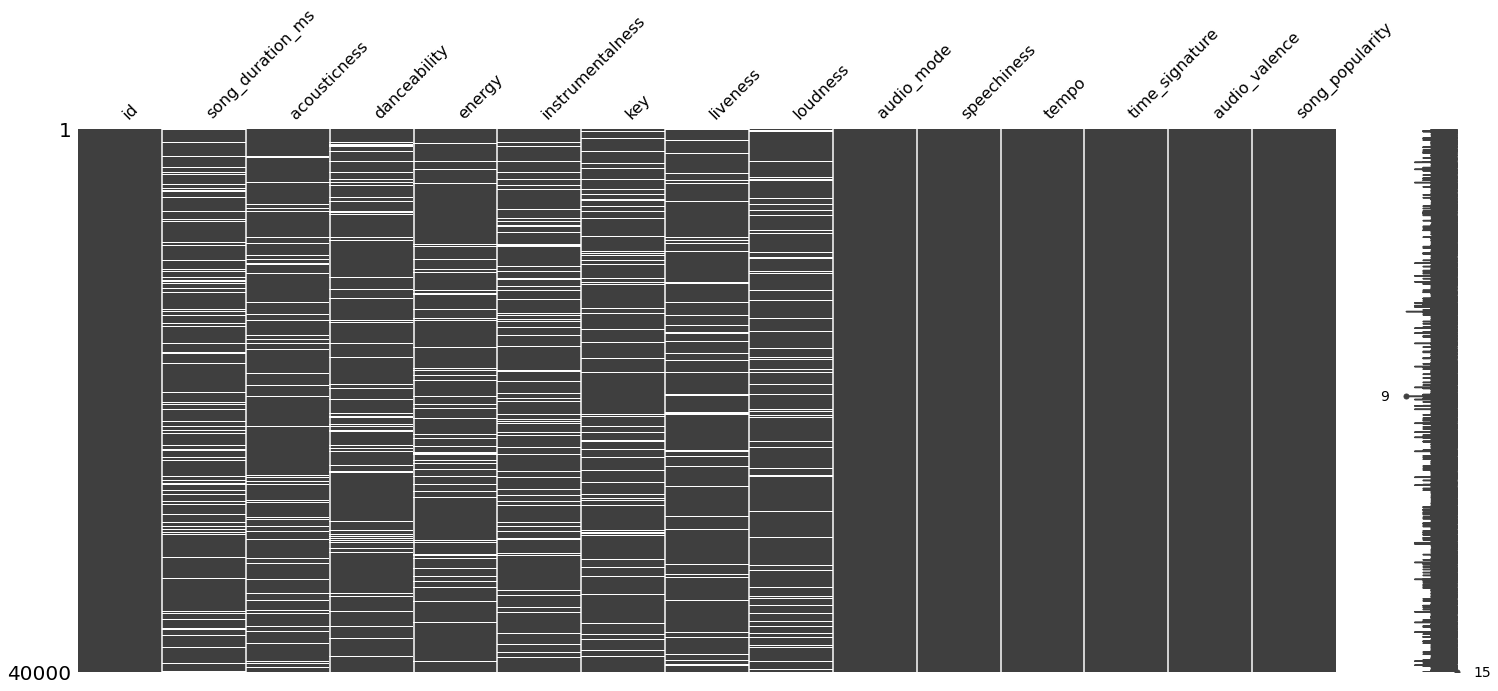

In [6]:
msno.matrix(train)

In [ ]:
train.isnull().mean() * 100

song_duration_ms   10.252500
acousticness        9.980000
danceability       10.065000
energy              9.937500
instrumentalness    9.962500
key                10.162500
liveness           10.215000
loudness            9.892500
audio_mode          0.000000
speechiness         0.000000
tempo               0.000000
time_signature      0.000000
audio_valence       0.000000
song_popularity     0.000000
dtype: float64

<AxesSubplot:>

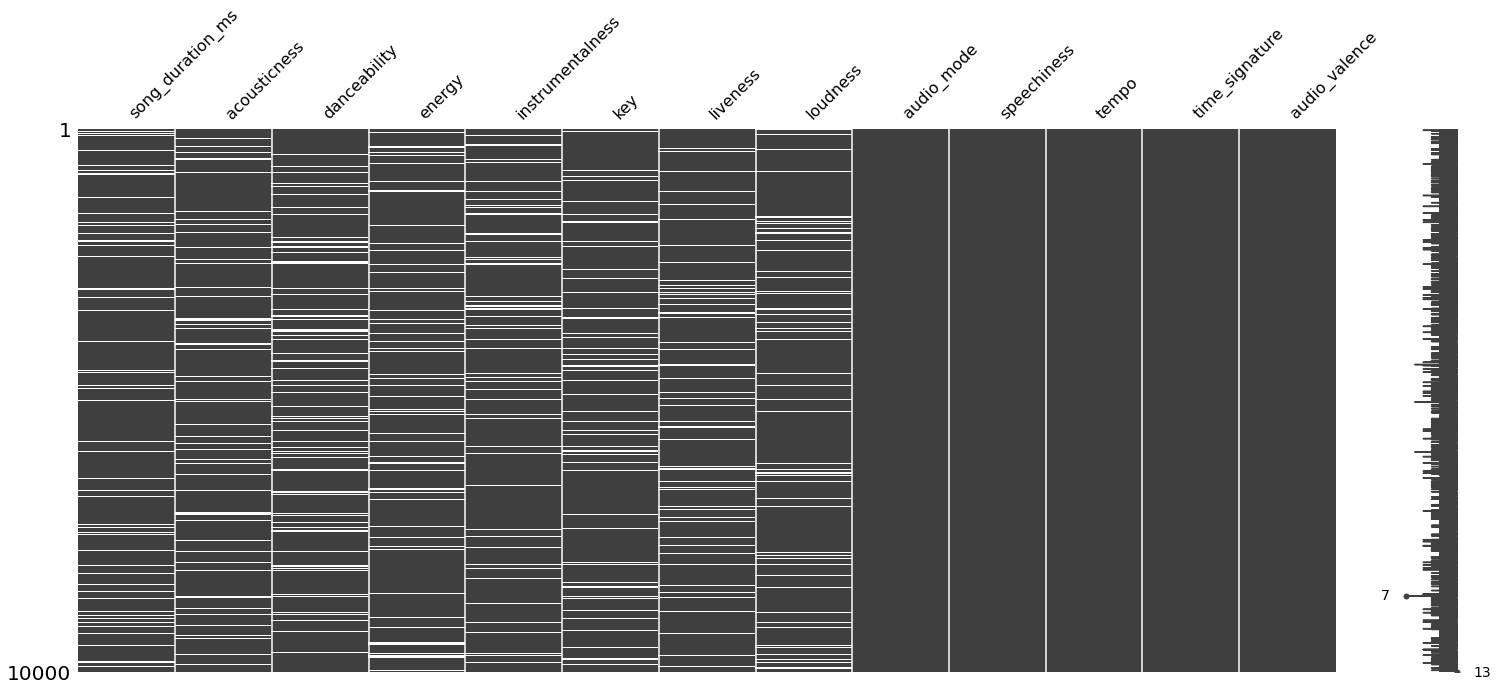

In [ ]:
msno.matrix(test)

In [ ]:
test.isnull().mean() * 100

song_duration_ms    9.570000
acousticness        9.500000
danceability        9.760000
energy             10.550000
instrumentalness   10.000000
key                 9.920000
liveness           10.060000
loudness           10.260000
audio_mode          0.000000
speechiness         0.000000
tempo               0.000000
time_signature      0.000000
audio_valence       0.000000
dtype: float64

Let's check the distribution on target in training data

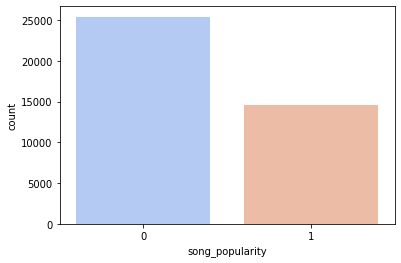

In [11]:
sns.countplot(train['song_popularity'], palette='coolwarm')

In [12]:
X = train.drop('song_popularity', axis=1).copy()
y = train['song_popularity'].copy()
X_test = test.copy()

del train
gc.collect()
del test
gc.collect()

0

In [13]:
def feature_engineering(df):
    df['NaN_row'] = df.isna().sum(axis=1)
    df['std'] = df.std(axis=1)
    return df

X = feature_engineering(X)
X_test = feature_engineering(X_test)

In [14]:
X.head()

,id,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,NaN_row,std
0,0,212990.000000,0.642286,0.856520,0.707073,0.002001,10.000000,nan,-5.619088,0,0.082570,158.386236,4,0.734642,1,56920.476210
1,1,nan,0.054866,0.733289,0.835545,0.000996,8.000000,0.436428,-5.236965,1,0.127358,102.752988,3,0.711531,1,27.355889
2,2,193213.000000,nan,0.188387,0.783524,-0.002694,5.000000,0.170499,-4.951759,0,0.052282,178.685791,3,0.425536,1,51634.537055
3,3,249893.000000,0.488660,0.585234,0.552685,0.000608,0.000000,0.094805,-7.893694,0,0.035618,128.715630,3,0.453597,0,64519.723984
4,4,165969.000000,0.493017,nan,0.740982,0.002033,10.000000,0.094891,-2.684095,0,0.050746,121.928157,4,0.741311,1,44354.207015


In [19]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale', StandardScaler())
])

X = pd.DataFrame(columns=X.columns, data=pipeline.fit_transform(X))
X_test = pd.DataFrame(columns=X_test.columns, data=pipeline.fit_transform(X_test))

In [20]:
X.head()

,id,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,NaN_row,std
0,-1.732008,0.471561,1.328643,1.560957,0.104510,-0.217778,1.552119,-0.387545,0.455719,-0.687808,-0.138019,1.598291,1.154896,0.648823,0.227218,0.581115
1,-1.731921,-0.134369,-0.728254,0.878389,0.740795,-0.224824,0.926482,1.685372,0.559162,1.453895,0.397799,-0.527746,-0.752053,0.551451,0.227218,-2.579077
2,-1.731834,0.016435,-0.428285,-2.139772,0.483149,-0.250676,-0.011973,-0.149173,0.636370,-0.687808,-0.500360,2.374043,-0.752053,-0.653509,0.227218,0.287502
3,-1.731748,1.320806,0.790712,0.058325,-0.660129,-0.227540,-1.576066,-0.671354,-0.160036,-0.687808,-0.699715,0.464423,-0.752053,-0.535282,-0.936065,1.003224
4,-1.731661,-0.610528,0.805969,0.185721,0.272450,-0.217555,1.552119,-0.670762,1.250245,-0.687808,-0.518729,0.205038,1.154896,0.676921,0.227218,-0.116892


In [21]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc

In [23]:
params = {  'objective': 'binary', 
            'n_estimators': 20000,
            'max_depth': 6,
            'learning_rate':  0.01, 
            'min_child_weight': 256,
            'min_child_samples': 15, 
            'reg_alpha': 10, 
            'reg_lambda': 0.1, 
            'subsample': 0.6, 
            'subsample_freq': 1, 
            'colsample_bytree': 0.4,}

In [26]:
%%time
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=786)

preds = []
scores = []
feature_importance_df = pd.DataFrame()

for fold, (idx_train, idx_valid) in enumerate(kf.split(X, y)):
    X_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
    X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]
    
    model = LGBMClassifier(**params)
    
    model.fit(X_train, y_train,
              eval_set = [(X_valid, y_valid)],
              verbose = False,
              early_stopping_rounds = 300)
    
    pred_valid = model.predict_proba(X_valid)[:,1]
    fpr, tpr, _ = roc_curve(y_valid, pred_valid)
    score = auc(fpr, tpr)
    scores.append(score)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = X.columns
    fold_importance_df["importance"] = model.feature_importances_
    fold_importance_df["fold"] = fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    print(f"Fold: {fold + 1} Score: {score}" "\n")
    
    
    test_preds = model.predict_proba(X_test)[:,1]
    preds.append(test_preds)
    
print(f"Overall Validation Score: {np.mean(scores)}")

Fold: 1 Score: 0.5788363281280574

Fold: 2 Score: 0.5844682173547043

Fold: 3 Score: 0.5698242797661958

Fold: 4 Score: 0.5770747265091221

Fold: 5 Score: 0.5732738012366185

Fold: 6 Score: 0.5684584036202768

Fold: 7 Score: 0.565349319363365

Fold: 8 Score: 0.5831226074108611

Fold: 9 Score: 0.5702556448105301

Fold: 10 Score: 0.5879380050272028

Overall Validation Score: 0.5758601333226934
CPU times: user 1min 26s, sys: 921 ms, total: 1min 27s
Wall time: 44.4 s


In [25]:
# cols = (feature_importance_df[["Feature", "importance"]]
#         .groupby("Feature")
#         .mean()
#         .sort_values(by="importance", ascending=False)[:107].index)
# best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

# plt.figure(figsize=(14,28))
# sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
# plt.title('Features importance (averaged/folds)')
# plt.tight_layout()
# plt.savefig('FI.png')

In [27]:
predictions = np.mean(np.column_stack(preds),axis=1)

ss['song_popularity'] = predictions
ss.to_csv('lgbm_2000_n_est.csv', index=False)
ss.head()

,id,song_popularity
0,0,0.418699
1,1,0.475665
2,2,0.313147
3,3,0.333531
4,4,0.359516
